# Metrics and Errors

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import re
import ast
import matplotlib.pyplot as plt
from metrics_utils import *
from pathlib import Path

sns.set_theme()

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 1. Generate synthetic data

Produces a set of confussion matrices, simulating two types of errors: experimental and model errors. 

- Model errors are reproduced by random horizontal swaps (eg. a sample labeled as a positive prediction is changed to a negative prediction). 
- Experimental error are reproduced by vertical swaps (eg. an actual positive sample is considered as a true negative).

Given a positive proportion (P), a percentile of true positive (TP) and a percentile of true negative (TN), a confussion matrix is defined which will be then used as a seed to create more random matrices.  

In [2]:
def create_cm_seed(positive_prop, percentile_tp, percentile_tn=0.8):
    """Create a confussion matrix with normalized values. 

    Args:
        positive_prop (float): proportion of positive samples
        percentile_tp (float): proportion of true positive over positives samples
        percentile_tn (float, optional): proportion of true negatives over positives samples. Defaults to 0.8.

    Returns:
        [type]: [description]
    """
    tp = percentile_tp * positive_prop 
    fn = positive_prop-tp
    tn = (1-positive_prop) * percentile_tn
    fp = 1-tp-fn-tn
    return [tn, fp, fn, tp, positive_prop, percentile_tp]

From each confussion matrix seed, generate `m_matrices` which will have an error proportion `error_prop`. 

Simulate errors by random horizontal and/or vertical swaps.

In [3]:
def set_experiment(confusion_matrix_args, error_type="exp", error_prop=0.15, seed=1, alpha=0.10):
    """ 
        
    Args:
        confusion_matrix_args ([dicctionary]): Parameters that defines a seed confussion matrix
        error_type ([string]): Type of error to be simulated. "exp" refers to experimental error, "model" to model errors
        and "both" to both error types.
        seed (int, optional): Random seed to simulate errors. Defaults to 1.
        alpha (float, optional): [description]. When error_type is "both", alpha is the fraction of experimental errors,
        the remaining proportion 1-alpha corresponds to model error.

    Returns:
        [type]: [description]
    """
    np.random.seed(seed=seed)
    imbalances = confusion_matrix_args["positive"] 
    percentiles_tp = confusion_matrix_args["tn_percentil"]
    n_matrix_size = confusion_matrix_args["n_size"]
    m_matrices = confusion_matrix_args["m_matrices"]
    
    # Generate samples from each confussion matrix seed
    seed_confusion_matrix = [create_cm_seed(imb, ptl) for imb in imbalances for ptl in percentiles_tp]
    df = pd.DataFrame(seed_confusion_matrix, columns=["tn", "fp", "fn", "tp", "imbalance", "percentil_tp"])
    df.iloc[:, 0:4] = df.iloc[:, 0:4] * n_matrix_size
    df[["tn", "fp", "fn", "tp"]]  = df.iloc[:, 0:4].round(0).astype(int)
    idx_repeated = df.index.repeat(m_matrices)
    df = df.loc[idx_repeated]
    df = df.reset_index(drop=True)
    
    # Simulate errors by random pick & puts
    errors = n_matrix_size * error_prop
    model_error = round(errors * alpha)
    exp_error = errors-model_error
    for i in range(len(df)):
        permutation_remaining = errors
        while permutation_remaining > 0:
            flip_cm_class = np.random.randint(0,2)
            class_from = np.random.randint(0,2)
            class_to = not class_from
            if error_type == "model":
                index_cm_from = flip_cm_class*2 + class_from
                index_cm_to = flip_cm_class*2 + class_to
            elif error_type == "exp":
                index_cm_from = flip_cm_class + class_from * 2
                index_cm_to = flip_cm_class + class_to * 2
            elif both == "model-exp":
                
            else:
                raise ValueError("Invalid type of error. Cannot simulate. Try 'exp' or 'model'.") 
            
            if df.iloc[i,index_cm_from] == 0: continue
            else: 
                df.iloc[i,index_cm_from] -= 1
                df.iloc[i,index_cm_to] += 1
                permutation_remaining -= 1
    
    confusion_matrix_args["seed"] = seed
    confusion_matrix_args["error_type"] = error_type
    confusion_matrix_args["error_prop"] = error_prop
    
    data_info = {"data": df,
                 "metadata": confusion_matrix_args}
    
    return data_info

In [61]:
round(1.2)

1

In [4]:
def add_metric_to(df, metric, average):
    """ Compute and add metric score as a new column. df must contain confussion matrices.
    Args:
        df ([pandas dataframe]): confussion matrices.
        metric ([str]): possible options: "recall", "F1", "precision", "matthew".
        average ([str]): way to average score across classes. Possible options: "macro", "micro", "weighted".
    Returns:
        [pandas dataframe]: df with metric score as column.
    """
    if not metric.startswith("matthew"):
        name_metric = metric + "_" + average
    else: name_metric = metric
    df[name_metric] = df.apply(lambda row: from_row_get_metric(row, metric=metric, m_average=average), axis=1)

## Experiments


### 1. Search complement metric

Recall is the deafault metric by problem definition. Matthew es the metric to benchmark with.
Metrics complements is measured by how well is possible to discern them. 

#### Model error



#### Experiment error

### 2. Error variability by matrix size (n)


### 3. Metric's Distribution Overlap

### Extrapolación 

Cada matrix de confusión representa la performance del modelo para un conjunto de experimentos llevados 
en el laboratorio para una amina en particular.

Nosotres estamos confiando los resultados del trabajo en un subconjunto de datos para cada amina (~200 datos) 

Queremos saber si podemos extrapolar:
    - en qué condiciones se puede entrenar para que extrapole
    - si para algunas funciona mejor, por qué 

Supongamos un espacio de entrenamiento finito discretizable acotado:
    - por conocimiento del problema (ej. concentración ácido < 5 M, temperatura < 130°)
    - por metodología/intrumentación experimental

Luego si tuviésemos el total de los datos posibles y corríamos el modelo, podríamos armar una matriz 
que indique fielmente cómo es la performance del modelo con respecto a esa amina. 
Sea esta la **matriz semilla**. 

Luego, al trabajar con un subconjunto de ese espacio total, la matriz experimental será un tanto "similar" 
a la matriz semilla (lo cual modelaremos mediante np.random).

De modo que tendremos muchas posibles mediciones de performance del modelo. 
Alguna de ellas se corresponde con nuestros datos...solo una. 
¿Qué tanto podemos confiar en ella?

OBS: Con muchos posible subconjuntos de datos del real, podemos tener la misma matriz. 
Cada matriz es una clase de equivalencia de los subconjuntos (x, y_true, y_pred).


Supongamos que tenemos muchos datos hechos en el laboratorio para cada amina.
En el caso ideal una cantidad significativa de experimentos nos habla de qué tan bien predice el modelo 
sobre datos de una amina en particular.
Nosotres solo tendremos acceso a una cantidad n_amine_sample, es decir, nos quedamos con 
una perspectiva sesgada de cómo anda el modelo.
    - Por ahí justo para esa cantidad de datos anda bien
    - Por ahí justo para esa cantidad y datos experimentales anda mal
    - Etc

Objetivo Principla: 
    Queremos identificar para qué aminas el modelo predice adecuadamente.

Para ello debemos:
    - Saber qué tanto se parece esa __sample__ al comportamiento esperado.
Queremos no equivocarnos al decir que el modelo no aprendió bien para una amina. Es decir, 
no queremos equivocarnos entre tipos dado que luego

Para ello: 
    1. Definimos una performance real del modelo para cada amina tipo (aka matrices semilla)
    2. Generamos matrices 
Diremos que el comportamiento esperado es  



In [5]:
metrics_to_compute = {
    "precision": {"micro", "macro"},
    "recall": {"micro", "macro"},
    "f1":{"macro", "weighted"},
    "matthew": {"score"}
}

Nos gustaría poder identificar facilmente con qué aminas está funcionando y vale la pena seguir vs con cuales renunciar. Análisis visual de dos métricas para descartar cómo está performando el modelo con respecto a la realidad de la amina

In [54]:
%matplotlib agg

In [8]:
def map_names_for_plot():
    metrics = ['precision_macro',
            'precision_micro',
            'recall_macro',
            'recall_micro',
            'f1_weighted',
            'f1_macro',
            'matthew']
        
    map_names = { metric: metric.replace("precision", "Precisión")
                .replace("_", " ")
                .replace("f1", "F1")
                .replace("recall", "Recall")   
                .replace("matthew", "Matthew")   
                for metric in metrics}
    map_names["percentil_tp"] = "Percentil TP"
    map_names["imbalance"] = "Desbalance"
    return map_names

In [11]:
positive_proportions = [0.10, 0.4]
tp_percentiles = [0.25,0.5,0.75]


m_matrices_ls = [250]
n_size_ls = [75, 300, 700]

def run_experiment(error_type, m_matrices_ls, n_size_ls, 
                   positive_proportions=[0.10, 0.4],
                   tp_percentiles=[0.25,0.5,0.75],
                   n_run=1, path=""):
    
    confusion_matrix_args = {"positive":positive_proportions,
                             "tn_percentil":tp_percentiles}
    
    data_folder = Path(path)
    data_folder.mkdir(parents=True, exist_ok=True)
    files = []
    
    for seed in range(n_run):
        # using default 0.8 for true negative proportion
        for n_size in n_size_ls:
            for m_matrices in m_matrices_ls:
                confusion_matrix_args["n_size"] = n_size
                confusion_matrix_args["m_matrices"] = m_matrices
                data_info = set_experiment(confusion_matrix_args, error_type = error_type, error_prop = 0.15, seed=seed)

                for metric in metrics_to_compute.keys():
                    for average in metrics_to_compute[metric]:
                        add_metric_to(data_info["data"], metric, average)
                
                #if 'tn_percentil' in data_info["metadata"]: del data_info["metadata"]['tn_percentil']
                file_name = Path(data_folder / (str(data_info["metadata"]) + ".csv") )
                data_info["data"].to_csv(file_name, index=False)
                files.append(file_name)
    return files


In [238]:
files_test = run_experiment(error_type="model", m_matrices_ls=[10], n_size_ls=[10],
               n_run=1, path="test2")

In [12]:
files_exp_test = run_experiment(error_type="exp", m_matrices_ls=m_matrices_ls, n_size_ls=n_size_ls,
               n_run=1, path="exp_model")

In [15]:
def plot_files(path, plot_fun, plot_args={}):
    path_src = Path(path)
    if path_src.is_dir():
        plot_folder = Path(path + "_plots")
        plot_folder.mkdir(parents=True, exist_ok=True)
        for src_filename in path_src.iterdir():
            plot_fun(src_filename, plot_folder, plot_args) 
    #elif path_src.is_file(): 
    #   plot_fun(path_src, plot_args, Path(plot_folder/src_filename)) 
        

In [59]:
sns.set_context('talk')

def map_from_filename(file_name):
    str_map_match = re.search(r'\{.*\}', file_name).group(0)
    return ast.literal_eval(str_map_match)

def plot_compare_metrics_distribution(file_path, plot_folder, plot_args={}):
    map_cols = map_names_for_plot()
    all_metrics = ["precision_macro", "precision_micro", "f1_weighted", "f1_macro", "matthew"]
    metrics = plot_args.get("metrics_to_plot", all_metrics)
    df = pd.read_csv(file_path)
    df = df.rename(columns=map_cols)
    filename = file_path.stem
    plot_variables = map_from_filename(filename)
    for metric in metrics:
        ax = sns.displot(df, x=map_cols[metric], hue=map_cols["percentil_tp"], kind="kde",
                         col=map_cols["imbalance"], fill=True, common_norm=False, palette="Paired",
                         alpha=.5, linewidth=0)
        ax.set(ylabel='Distribución')
        ax.fig.subplots_adjust(top=0.85)
        plot_title = "Prop. Error: {} | n matrix: {} | m matrices: {} | semilla: {}".format(plot_variables["error_prop"],
                                                                                            plot_variables["n_size"],
                                                                                            plot_variables["m_matrices"],
                                                                                            plot_variables["seed"],
                                                                                            )
        ax.fig.suptitle(plot_title, fontsize=14)
        plot_path = plot_folder / (filename + "_"+ metric + ".png")
        plt.savefig(plot_path,facecolor='w', transparent=False, dpi=150)
        

In [60]:
plot_files("exp_model", plot_compare_metrics_distribution, {})

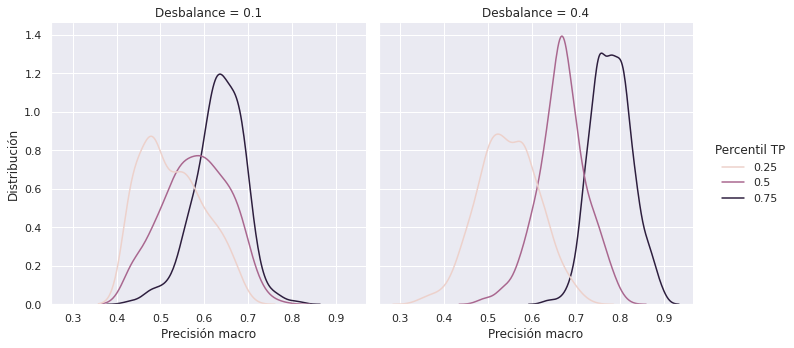

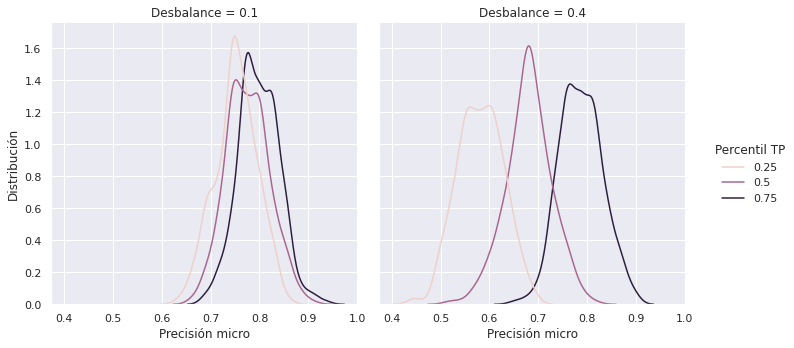

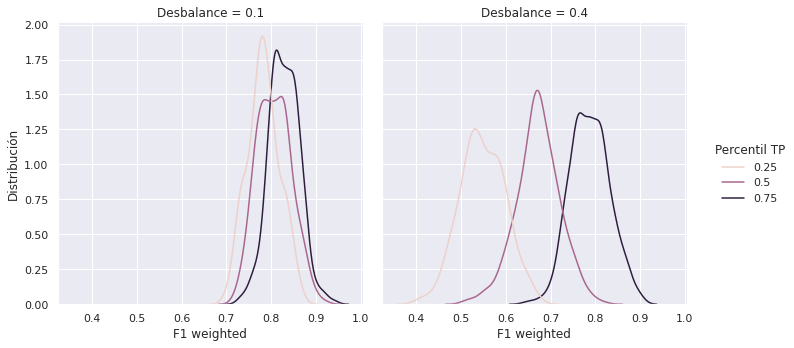

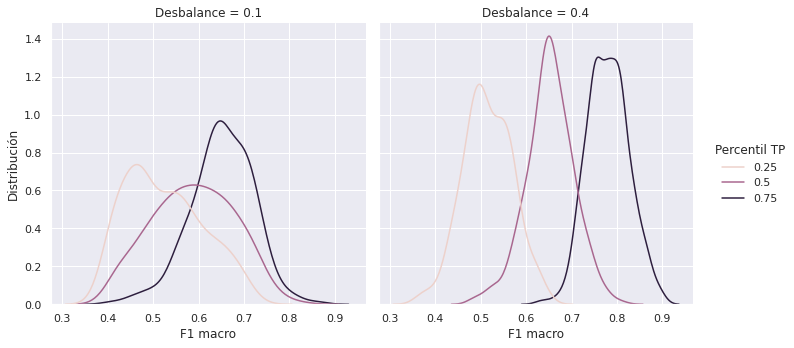

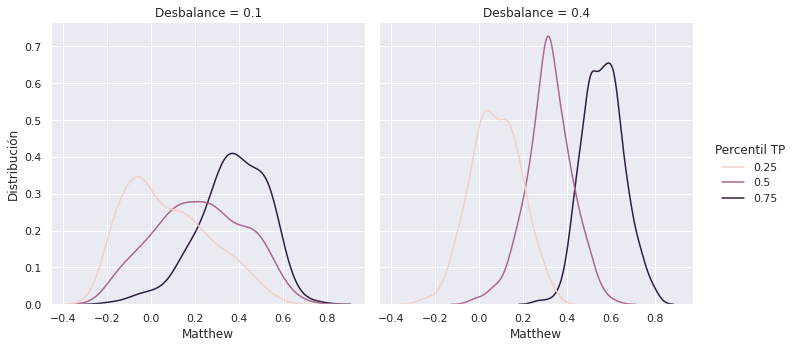

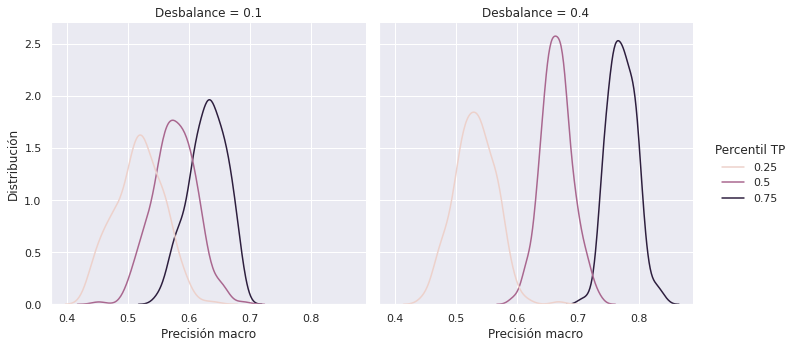

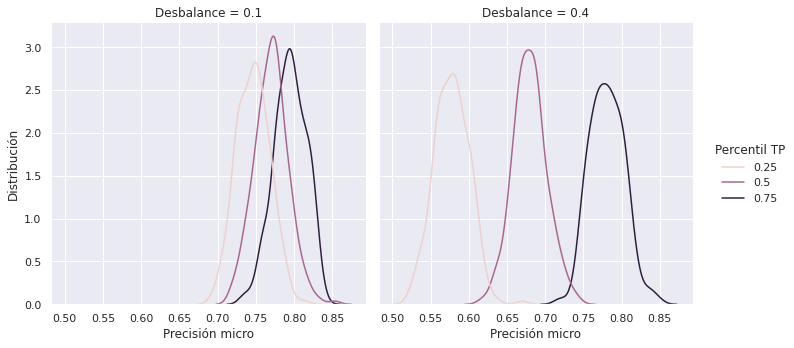

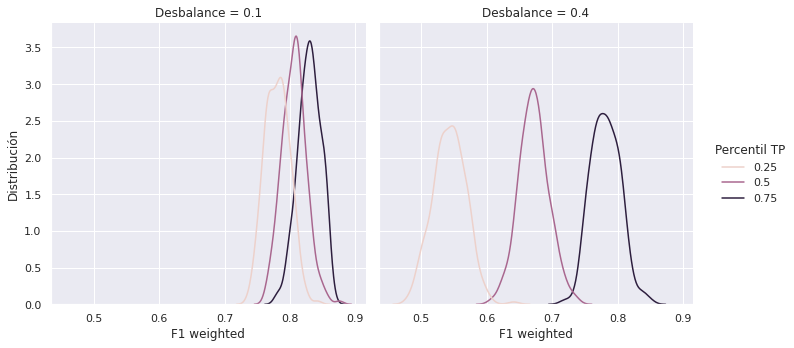

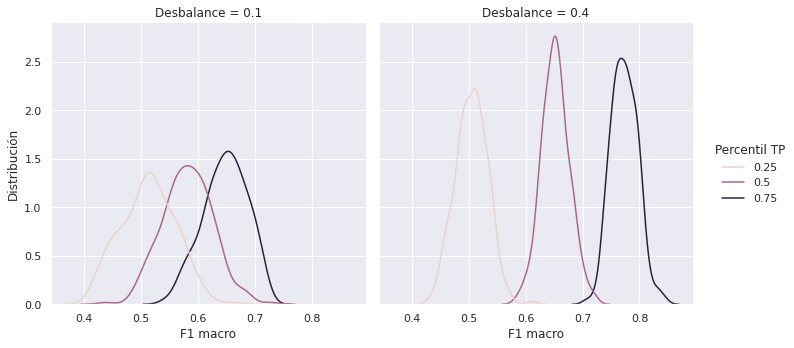

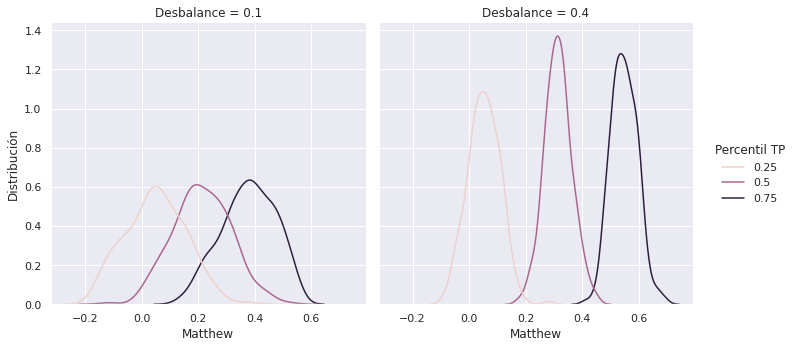

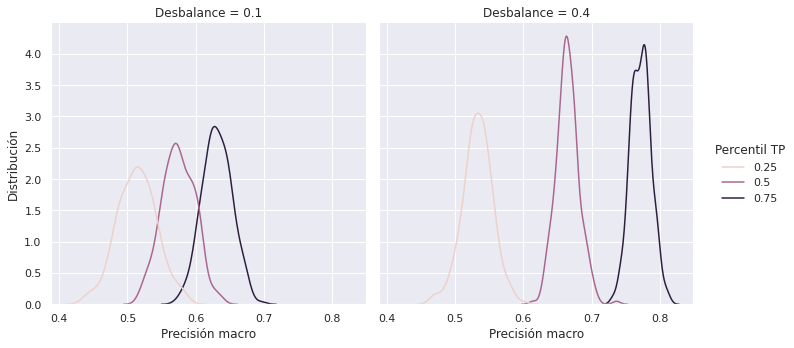

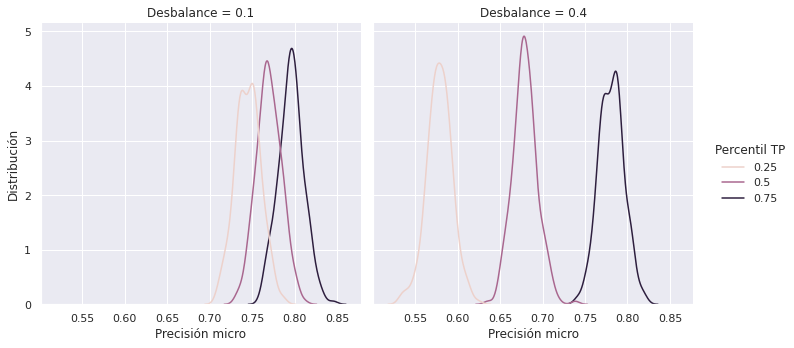

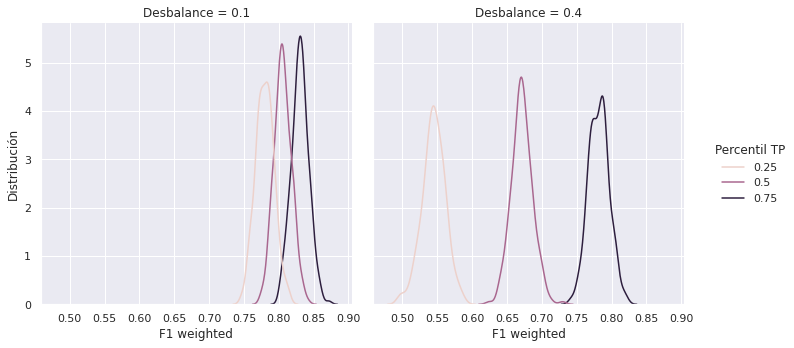

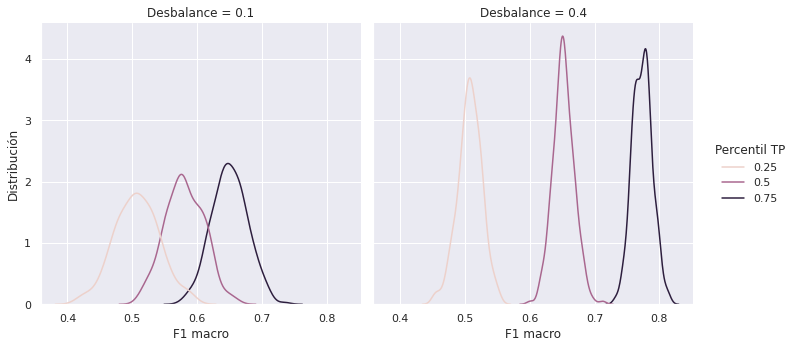

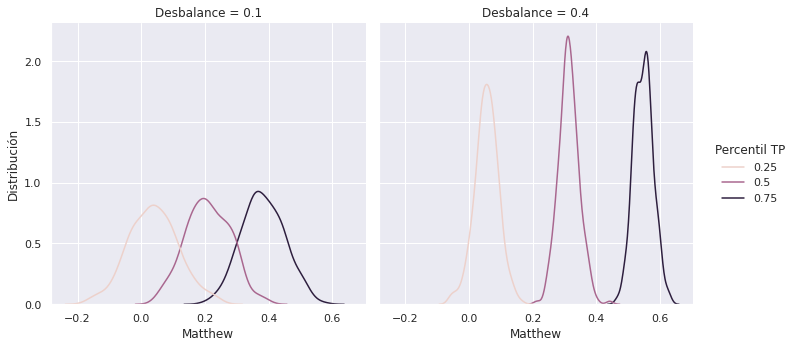

In [122]:
plot_files("test", plot_compare_metrics_distribution, {}) 

### Imbalance affects distribution Overlapping

In [50]:
n_matrix_size = [500]
positive_proportions = [0.10, 0.2, 0.3, 0.4]
tp_percentiles = [0.25,0.5,0.75]
cm_samples = [250]

#distribution_plot(dataset, seed=seed, n_matrix_size=n_size, cm_sample=cm_sample)


In [51]:
from scipy.stats import norm

%matplotlib inline

In [33]:
def plot_joint(df, seed, x_metric, y_metric, hue_col, map_cols, imbalance, n, cm_sample):
    df = df[df.imbalance == imbalance]
    df.rename(columns=map_cols, inplace=True)
    g = sns.jointplot(data=df, x=map_cols[x_metric], y=map_cols[y_metric], hue=map_cols[hue_col], xlim = (-0.4,1.15), ylim = (0,1.1))
    g.plot_joint(sns.kdeplot, zorder=3, levels=1)
    g.plot_marginals(sns.rugplot, height=.05, clip_on=True)
  # g.savefig("img/recall_vs_{}_imbalance_{}.jpg".format(x_metric, imbalance), transparent=True,  facecolor='w')
    plt.savefig("img_final_cross/recall_vs_{}_imbalance_{}_seed_{}_n_{}_cm_{}.png".format(x_metric, imbalance, seed, n, cm_sample),facecolor='w', transparent=False, dpi=150)

def generate_plots(df, seed, n_matrix_size, cm_sample):
    posible_complement = ["precision_macro", "precision_micro", "f1_weighted", "f1_macro", "matthew"]

    for metric in posible_complement:
        for imbalance in positive_proportions:
            plot_joint(df, seed, metric, "recall_macro", "percentil_tp", map_names, imbalance, n_matrix_size, cm_sample)

## Cómo el desbalance puede afectar a las métricas

A menos desbalance, hay compuestos que teniendo datos donde cristaliza poco y otros para el cual cristaliza mucho..vamos a llegar
a que pueden tener las mismas métricas. El error modelado nos afecta mucho

In [35]:
plot_imbalance_complement_metric(dataset, "precision_macro", "recall_macro")
#plot_imbalance_complement_metric(dataset, "precision_macro", "precision_macro")

In [ ]:
import plotly.express as px


def plot_imbalance_complement_metric(df, x_metric, y_metric):
    "Plot how imbalance proportion affect two complement metrics"
    fig = px.density_contour(df, x=x_metric, y=y_metric, color="percentil_tp", facet_col="imbalance")
    x_min = min(df[x_metric].min(),0)
    y_min = min(df[y_metric].min(),0)
    fig.update_layout(yaxis_range=[y_min,1.1])
    fig.update_layout(xaxis_range=[x_min,1.1])
    fig.show()
    
    
def plot_complement_comparision(df, target_metric, possible_complements):
    fig = px.density_contour(df, x=x_metric, y=target_metric, z="percentil_tp", color="percentil_tp", facet_col="imbalance", 
                             trendline="lowess")
    x_min = min(df[x_metric].min(),0)
    y_min = min(df[y_metric].min(),0)
    fig.update_layout(yaxis_range=[y_min,1.1])
    fig.update_layout(xaxis_range=[x_min,1.1])
    fig.show()

In [111]:
#macro  similar average
metrics_to_compare = [
            ("precision_macro", "recall_macro"),
         #   ("precision_macro", "recall_macro"),
            ("precision_macro", "recall_micro"),
            ("f1_macro", "recall_macro"),
            ("f1_weighted", "recall_macro"),
            ("matthew", "precision_macro")
        ]

for metrics_tuple in metrics_to_compare: 
    scatter_plotly(dataset, metrics_tuple[0], metrics_tuple[1], "labels")

In [117]:
metrics_to_compute = {
    "precision":{"macro"},
    "recall": {"micro", "macro"},
    "f1":{"weighted"},
}

metrics_to_compare = [
            ("precision_macro", "recall_micro"),
            ("f1_weighted", "recall_macro")
          ]

# datos por cada amina, para algunas tengo mucho y para otras muy poco
n_samples = [20,40,60, 80]
datasets = [set_experiment(seed_confusion_matrix, labels, n_matrix_size=sample, 
                         cm_samples=15, error_prop=0.15)
           for sample in n_samples]

for metrics_tuple in metrics_to_compare: 
    for i, dataset in enumerate(datasets):
        for metric in metrics_to_compute.keys():
            for average in metrics_to_compute[metric]:
                add_metric_to(dataset, metric, average)
        scatter_plotly(dataset, metrics_tuple[0], 
                       metrics_tuple[1], "labels", 
                       "n matrix: {}".format(n_samples[i]))

In [94]:
metrics_to_compute = {
    "precision":{"macro"},
    "recall": {"micro", "macro"},
    "f1":{"weighted"},
}

metrics_to_compare = [
            ("precision_macro", "recall_micro"),
            ("f1_weighted", "recall_macro")
          ]

# datos por cada amina, para algunas tengo mucho y para otras muy poco
n_samples = 80
datasets = [set_experiment(seed_confusion_matrix, labels, n_matrix_size=sample, 
                         cm_samples=15, error_prop=0.15)
           for sample in n_samples]

for metrics_tuple in metrics_to_compare: 
    for dataset in datasets:
        for metric in metrics_to_compute.keys():
            for average in metrics_to_compute[metric]:
                add_metric_to(dataset, metric, average)
        scatter_plotly(dataset, metrics_tuple[0], metrics_tuple[1], "labels")

TypeError: 'int' object is not iterable

In [202]:
from adjustText import adjust_text

def scatter_text(x, y, text_column, data, title="", xlabel="", ylabel=""):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    texts = []
    # Add text besides each point
    for line in data.index:
      #texts.append(p1.text(data[x][line]+0.01, data[y][line], data[text_column][line]))
      p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='small', color='black')
   
    #adjust_text(texts, data[[text_column]])
    return p1

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_micro', ylabel='f1_macro'>

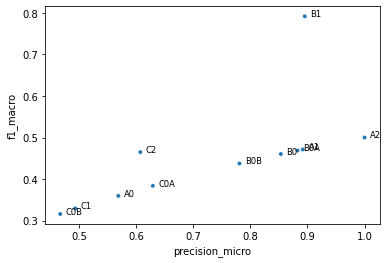

In [203]:
scatter_text("precision_micro", "f1_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='recall_macro', ylabel='recall_micro'>

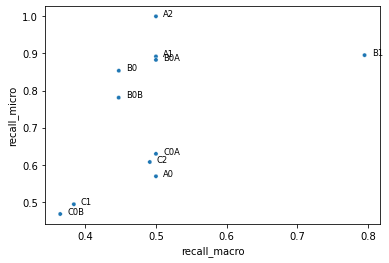

In [204]:
scatter_text("recall_macro", "recall_micro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_macro', ylabel='f1_macro'>

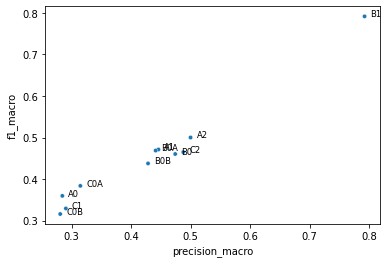

In [205]:
scatter_text("precision_macro", "f1_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_macro', ylabel='recall_macro'>

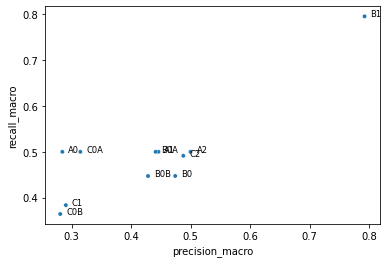

In [206]:
scatter_text("precision_macro", "recall_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_micro', ylabel='recall_micro'>

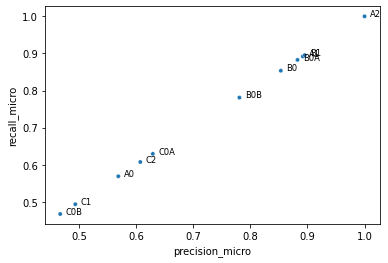

In [207]:
scatter_text("precision_micro", "recall_micro", "level", dataset_mean, "title", "recall", "positive rate")


In [208]:
metrics_names = []
metric = []
beta = []
average = []

experiments = pd.DataFrame.from_dict({"name": metrics_names,
                                     "metric": metric,
                                     "beta" : beta,
                                     "average": average
                                    })

In [22]:
metrics_names = ["accuracy", "f1", "precision", "hit rate", "recall"]
metrics_funs = [accuracy, F1, precision, hit_rate, recall]
for (label, metric) in zip(metrics_names, metrics_funs):
    dataset[label] = dataset.apply(lambda row : metric(row), axis=1)

In [23]:
dataset.groupby(by="level").mean()

,accuracy,f1,precision,hit rate,recall
level,,,,,
A,0.650294,0.000000,1.000000,0.000000,0.000000
B,0.879675,0.000000,1.000000,0.000000,0.000000
C,0.800472,0.000000,1.000000,0.000000,0.000000
D,0.882558,0.000000,1.000000,0.000000,0.000000
E,0.907867,0.334926,0.675900,0.324100,0.675900
F,0.700213,0.250248,0.429452,0.570548,0.429452
